### Information
- Author: Charles Lamb
- Date: 11/18/2023

### Model Description

- Simulation models the claim flow of GAP claims within a call center.  GAP is a special type of warranty.  A call center typical handles many types of warranties.  An initial phone call is routed to a First Notice of Loss (FNOL) handler.  This individual collects initial information and determines what type of warranty the customer is calling about.  The FNOL handler then passes the phone call to a specialized adjuster who handles only a specific type of warranty (in this case GAP).  This adjuster handles the remainder of the phone call.  Simulation is a discrete event simulation

### Event Graph

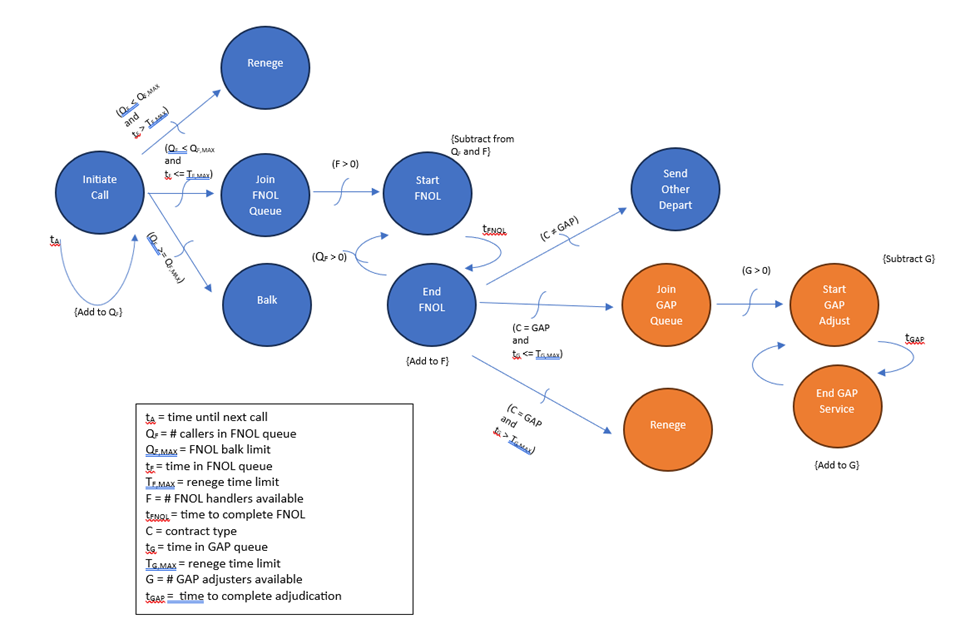

### References

- General code structure influenced by Joe Tatusko's "Simulating Real-World Processes in Python with SimPy": https://realpython.com/courses/simulating-processes-simpy/
- Balking functionality incoprorated based on queue function on Simpy resources: https://simpy.readthedocs.io/en/latest/api_reference/simpy.resources.html
- Renegging funcionality based on Simpy's Bank Renge example: https://simpy.readthedocs.io/en/latest/examples/bank_renege.html

### Code

In [1]:
import simpy, random, statistics, pandas as pd, queue, numpy as np

In [2]:
#function to log releveant information
def logger(env,caller,call_center,action):
    #record.append(f'caller: {caller}, time: {env.now}, action: {action}, #_already_in_FNOL_que: {len(call_center.fnol_handler.queue)}')
    record.append([caller, env.now, action, len(call_center.fnol_handler.queue)])

In [3]:
#setting up a call center object that contains resource constraints and organization processes
class Call_Center(object):
    def __init__(self, env, num_fnol, num_adj,min_fnol_time,max_fnol_time,mean_adj_t,min_adj_t,max_adj_t):
        self.env = env
        self.fnol_handler = simpy.Resource(env, num_fnol) #fnol handler is a company employee that answers phone and collects info
        self.adjuster = simpy.Resource(env, num_adj) #adjuster is a compnay employee that decides claim outcome
        
    def fnol(self,caller,min_fnol_time,max_fnol_time): #fnol adjuster collects initial information
        yield self.env.timeout(np.random.uniform(min_fnol_time,max_fnol_time))
    
    def adjudication(self,caller,mean_adj_t,min_adj_t,max_adj_t): #fnol adjuster passes call to adjuster for a decision
        #yield self.env.timeout(np.random.uniform(min_adj_t,max_adj_t))
        try_service_time = np.random.exponential(scale = mean_adj_t)
        if (try_service_time < min_adj_t):
            yield self.env.timeout(min_adj_t)
        if (try_service_time > max_adj_t):
            yield self.env.timeout(max_adj_t)
        if (try_service_time >= min_adj_t) and (try_service_time <= max_adj_t):
            yield self.env.timeout(try_service_time)

In [4]:
#create a function that moves caller through required steps
def submit_claim(env, caller, call_center,balking_limit,min_fnol_renege_patience,max_fnol_renege_patience,
                min_adj_renege_patience,max_adj_renege_patience,avg_per_gap,min_fnol_time,max_fnol_time,
                mean_adj_t,min_adj_t,max_adj_t):
    
    arrive = env.now
    logger(env,caller,call_center,'join_fnol_que')
    patience = np.random.uniform(min_fnol_renege_patience,max_fnol_renege_patience) #setup fnol reneg agent
    patience2 = np.random.uniform(min_adj_renege_patience,max_adj_renege_patience) #setup adj reneg agent
    warranty_type = random.randint(1,1/avg_per_gap) #range of different warranty products
    
    if len(call_center.fnol_handler.queue) <= balking_limit - 1: #balk condition
        with call_center.fnol_handler.request() as request:     #request fnol resources
            results = yield request | env.timeout(patience)
            wait = env.now - arrive
            if request in results: #fnol reneg condition
                logger(env,caller,call_center,'start_fnol')
                yield env.process(call_center.fnol(caller,min_fnol_time,max_fnol_time))
                logger(env,caller,call_center,'end_fnol') 
            else:
                logger(env,caller,call_center,'renegged_fnol')
                return
        
        if warranty_type == 1/avg_per_gap: #only passes gap warranties forward
            logger(env,caller,call_center,'join_adj_que')  
            arrive2 = env.now
            with call_center.adjuster.request() as request2:     #request adjuster resources
                results2 = yield request2 | env.timeout(patience2)
                wait2 = env.now - arrive2
                if request2 in results2: #adh reneg condition
                    logger(env,caller,call_center,'start_adj')
                    yield env.process(call_center.adjudication(caller,mean_adj_t,min_adj_t,max_adj_t))
                    logger(env,caller,call_center,'end_adj')  
                else:
                    logger(env,caller,call_center,'renegged_adj')
                    return         
        else:
            logger(env,caller,call_center,'redirected_to_other_dept')  
    else:
        logger(env,caller,call_center,'balk_fnol')
    return

In [5]:
def run_call_center(env,num_fnol,num_adj,mean_call_per_minute,balking_limit,min_fnol_renege_patience,max_fnol_renege_patience,
                   min_adj_renege_patience,max_adj_renege_patience,avg_per_gap,min_fnol_time,max_fnol_time,
                   mean_adj_t,min_adj_t,max_adj_t):
    
    call_center = Call_Center(env, num_fnol, num_adj,min_fnol_time,max_fnol_time,mean_adj_t,min_adj_t,max_adj_t) #call the call center object
        
    caller = 1 #create an initial first caller
    yield env.timeout(1)
    env.process(submit_claim(env, caller, call_center,balking_limit,min_fnol_renege_patience,max_fnol_renege_patience,
                            min_adj_renege_patience,max_adj_renege_patience,avg_per_gap,min_fnol_time,max_fnol_time,
                            mean_adj_t,min_adj_t,max_adj_t))
    
    while True: #continue to produce callers at a poisson rate
        yield env.timeout(np.random.poisson(lam=1/mean_call_per_minute))
        caller +=1
        env.process(submit_claim(env, caller, call_center,balking_limit,min_fnol_renege_patience,max_fnol_renege_patience,
                                min_adj_renege_patience,max_adj_renege_patience,avg_per_gap,min_fnol_time,max_fnol_time,
                                mean_adj_t,min_adj_t,max_adj_t))

In [6]:
def main(num_fnol,num_adj,mean_call_per_minute,seed,balking_limit,min_fnol_renege_patience,max_fnol_renege_patience,
         min_adj_renege_patience,max_adj_renege_patience,avg_per_gap,min_fnol_time,max_fnol_time,runtime,
        mean_adj_t,min_adj_t,max_adj_t):
    random.seed(seed) #setup the seed
    env = simpy.Environment() #setup the environment
    env.process(run_call_center(env,num_fnol,num_adj,mean_call_per_minute,balking_limit,min_fnol_renege_patience,
                                max_fnol_renege_patience,min_adj_renege_patience,max_adj_renege_patience,avg_per_gap,
                               min_fnol_time,max_fnol_time,mean_adj_t,min_adj_t,max_adj_t)) #run the sim
    env.run(until=runtime) #number of simulation minutes to run

In [7]:
def fnol_service(df_log):
    activity_list = df_log['Activity'].values.tolist()
    return activity_list.count(['end_fnol']) / (activity_list.count(['end_fnol']) + activity_list.count(['renegged_fnol']) + activity_list.count(['balk_fnol']))

In [8]:
#Input explanation:
#num_fnol = the number of fnol handlers the call center has working
#num_adj = the number of gap adjusters the call center has working
#mean_call_per_minute = mean number of calls received per minute.  determines lamba of a poisson arrival distribution
#seed = sets random initial seed to ensure reproducability of results
#balking_limit = number of callers already in que such that new arriving customer will balk
#min_fnol_renege_patience = min time caller will wait in fnol que before renegging 
#max_fnol_renege_patience = max time caller will wait in fnol que before renegging 
#min_adj_renege_patience = min time caller will wait in GAP adjuster que before renegging 
#max_adj_renege_patience = max time caller will wait in GAP adjuster que before renegging 
#avg_per_gap = average percentage of incoming calls that relate to GAP.  Express as a fraction 1 over some number
#min_fnol_time = min time required to complete an fnol call. forms the lower bound of a uniform distribution
#max_fnol_time = max time required to complete an fnol call.  forms the upper bound of unform distribution
#runtime = # of minutes to run simulation
record = []
main(num_fnol=4,
         num_adj=3,
         mean_call_per_minute=1,
         seed=24,
         balking_limit=5, 
         min_fnol_renege_patience= 3, 
         max_fnol_renege_patience=8,
         min_adj_renege_patience= 6, 
         max_adj_renege_patience=8,
         avg_per_gap = 1/3,
         min_fnol_time = 1,
         max_fnol_time = 5,
         runtime = 60*8,
         mean_adj_t = 5,
         min_adj_t = 2,
         max_adj_t= 10)
columns = ['Call_ID','Time','Activity','#_in_FNOL_Que']
df_log = pd.DataFrame(data=record,columns=[columns])
print(fnol_service(df_log))

0.9858012170385395


In [9]:
#iterate through num_fnol to determine min handlers required to meet service standard
# columns = ['Call_ID','Time','Activity','#_in_FNOL_Que']
# for i in range(1,10):
#     main(num_fnol=i,
#          num_adj=20,
#          mean_call_per_minute=1,
#          seed=24,
#          balking_limit=5, 
#          min_fnol_renege_patience= 3, 
#          max_fnol_renege_patience=8,
#          min_adj_renege_patience= 6, 
#          max_adj_renege_patience=8,
#          avg_per_gap = 1/3,
#          min_fnol_time = 1,
#          max_fnol_time = 5,
#          runtime = 60*8,
#          mean_adj_t = 5,
#          min_adj_t = 2,
#          max_adj_t= 10)
#     del df_log
#     df_log = pd.DataFrame(data=record,columns=[columns])
#     print(f'{i}: {fnol_service(df_log)}')

In [10]:
#df[df['Activity']  == 'balk_fnol'].mean()

In [11]:
df_log.to_excel('output.xlsx')

In [12]:
#df_log